<center><h1>Group 2404 </h1></center>


<center><style>
table {
    font-size: 24px;
}
</style></center>

| Last Name          | First Name            |Student Number|
|--------------------|-----------------------|----------------|
| Malagoli           | Pietro                |2125711         |
| Boccanera          | Eugenia               |2109310         |
| Braidi             | Federico              |2122169         |
| Lovato             | Matteo                |2104269         |           

In [1]:
import itertools as it
import numpy as np
from numpy import exp, sqrt, abs
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 13

In [2]:
class Visualization:
    
    def create_coord(self, np, x0,f=1.0):      #returns 1 vector of np values, all x0 and 1 vector of np values normalized between -f/2 and f/2
        x=[x0] * np
        print(x)
        y=list(range(np))
        for i in range(np):
            y[i] = f*(y[i]/(np-1.) - 0.5)
        return (x,y)

    def mycolor(self, val):
        if val>0: return 'red'
        elif val<0: return 'blue'
        else: return 'black'

    def plotgraph_vert(self, RBM, epoch=0):
        A=2./RBM.w.max()
        for i in range(RBM.L):
            for j in range(RBM.M):
                ex, ey, col = (RBM.x1[i],RBM.x2[j]),(RBM.y1[i],RBM.y2[j]),self.mycolor(RBM.w[i][j])
                plt.plot(ex, ey, col, zorder=1, lw=A*abs(RBM.w[i][j]))          #plots the lines with width and color based on the weights
        
        A=300./(RBM.a.max()+RBM.b.max())
        
        for i in range(L):
            plt.scatter(RBM.x1[i], RBM.y1[i], s=A*abs(RBM.a[i]), zorder=2, c=self.mycolor(RBM.a[i]))     #plots the visible nodes

        for j in range(M):
            plt.scatter(RBM.x2[j], RBM.y2[j], s=A*abs(RBM.b[j]), zorder=2, c=self.mycolor(RBM.b[j]), marker="s")     #plots the hidden nodes

        plt.figaspect(1)
        plt.title(f'>0 red, <0 blue, epoch={epoch}')
        plt.show()
        
    def plotgraph(self, RBM,epoch=0):
        fig, ax = plt.subplots(1,1 , figsize=(7, 3.3))
        ax.tick_params(left=False,bottom=False)
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        
        A=1./max(RBM.w.max(),-RBM.w.min())
        for i in range(RBM.L):
            for j in range(RBM.M):
                ex, ey, col = (RBM.y1[i],RBM.y2[j]),(RBM.x1[i],RBM.x2[j]),self.mycolor(RBM.w[i][j])
                ax.plot(ex, ey, col, zorder=1, alpha=A*abs(RBM.w[i][j]))
        #A=300./(a.max()+b.max())
        A=300.
        for i in range(RBM.L):
            ax.scatter(RBM.y1[i],RBM.x1[i], s=A*abs(RBM.a[i]), zorder=2, c=self.mycolor(RBM.a[i]))
        for j in range(RBM.M):
            ax.scatter(RBM.y2[j], RBM.x2[j], s=min(300,A*abs(RBM.b[j])), zorder=2, c=self.mycolor(RBM.b[j]), marker="s")
        ax.set_title(f'>0 red, <0 blue, epoch={epoch}')
        ax.text(-0.51,0.85,"hidden\nlayer")
        plt.show()

In [3]:
class RBM:

    def __init__(self, M, filename,show_info=True):

        self.M = M                                                      # nr of hidden units
        self.N,self.L = self.read_file(filename)                             # nr of records and of visible units
        self.log_likehood_list= []            #initialize empty list to store log likehood
        sigma = sqrt(4. / float(self.L + self.M))                       # range of each initial weight
        np.random.seed(12345)                                           # random seed for reproducibility
        self.w = sigma * np.random.randn(self.L,self.M)                 # initial weights from a Normal distr
        self.a = sigma * np.random.randn(self.L)                        # initial visible bias from a Normal distr
        self.b = np.zeros(self.M)                                       # initial hidden bias from a Normal distr
        if(show_info):
            print("w=",self.w);print("a=",self.a);print("b=",self.b)        # print
        #w0,a0,b0=np.copy(w),np.copy(a),np.copy(b)
    
    def read_file(self, filename,SPINS=False):

        dname="DATA"
        fname=dname+filename
        self.v = np.loadtxt(fname, delimiter=" ",dtype=int)
        # store in v0, because later we will shuffle v
        v0 = np.copy(self.v)
        # to start, take a small subsample
        # v = v[1:11]
        N = len(self.v)
        L = len(self.v[1])

        self.SPINS = SPINS

        if self.SPINS:
            # sigmoid takes into account energy difference =2
            self.GAP=2
            # convert 0,1 -> -1,1
            self.v = 2*self.v - 1
            self.vmin=-1
        else:
            self.GAP=1
            self.vmin=0

        print(f'each of N={N} data has L={L} digits')
        return N,L

    def reset_params(self,show_info=True):

        sigma = sqrt(4. / float(self.L + self.M))                       # range of each initial weight
        np.random.seed(12345)                                           # random seed for reproducibility
        self.w = sigma * np.random.randn(self.L,self.M)                 # initial weights from a Normal distr
        self.a = sigma * np.random.randn(self.L)                        # initial visible bias from a Normal distr
        self.b = np.zeros(self.M)                                       # initial hidden bias from a Normal distr
        if(show_info):
            print("w=",self.w);print("a=",self.a);print("b=",self.b)        # print

    def show(self, epoch):
        
        vis=Visualization()
        (self.x1,self.y1)=vis.create_coord(np=self.L,x0=0)
        (self.x2,self.y2)=vis.create_coord(np=self.M,x0=1,f=0.7) 
        vis.plotgraph(epoch=epoch,RBM=self)

    def compute_cd_steps(self, cd_steps, h_i):
        hf=h_i  #set for the sake of the loop
        for i in range(cd_steps):
            # negative CD phase: generating fantasy vf
            vf = self.activate(hf,self.w.T,self.a,self.GAP)
            # one more positive CD phase: generating fantasy h from fantasy vf 
            hf = self.activate(vf,self.w,self.b,self.GAP)
        return vf,hf

    def activate(self, v_in, wei, bias, DE, info=False):      #returns a vector of length M with, for every hidden node, 0 or 1 based on if the node activates or not
        act = np.dot(v_in, wei) + bias
        n = np.shape(act)
        prob = 1. / (1. + exp(-DE*act))
        v_out = np.full(n, self.vmin, dtype=int) # a list on -1's or 0's
        v_out[np.random.random_sample(n) < prob] = 1 # activate the 1's with probability prob
        if info:
            print('input=', v_in)
            print('act=',act)
            print('prob=',prob)
            print('output=',v_out)
        return v_out

    def show_likelihood(self, log_likelihood_list):

        fig, ax = plt.subplots(1,1 , figsize=(7, 3.3))
        ax.plot(np.arange(0,len(log_likelihood_list),1),log_likelihood_list)
        ax.set_title("Log Likelihood Vs Epochs")
        ax.set_xlabel("Epoch index")
        ax.set_ylabel("Log Likelihood")
        plt.show()

    def train(self, learning_rate=1.,epochs=100,cd_steps=1,show_intermediate_graphs=False,show_info=False,minibatch_size=500, show_likelihood=True):

        #np.random.seed(12345)
        if(show_intermediate_graphs):
            self.show(0)

        l_rate = learning_rate
        mini, m = minibatch_size, 0
        log_likelihood_list = []

        # compute all possible config, let's take the first L values to be the activation of 
        # the visible nodes and the last M to be the act of the hidden ones
        conf = list(it.product((0, 1), repeat=self.L+self.M))

        for epoch in range(epochs):
            # aggregate normalization of batch statistics and learning rate in l_rate_m
            l_rate_m = l_rate / mini

            # Compute energy for each configuration with current values of w,a,b and use it to compute Z
            energies = []
            for x in conf:
                v_1 = x[:self.L]
                h_1 = x[self.L:]
                energy = -np.dot(v_1, self.a) - np.dot(h_1, self.b) - np.dot(np.dot(v_1, self.w), h_1)
                energies.append(energy)
            partition_function = sum(np.exp(-energy) for energy in energies)

            for k in range(self.N):
                if m==0:
                    # initialize averages in miniblock
                    v_data, v_model = np.zeros(self.L),np.zeros(self.L)
                    h_data, h_model = np.zeros(self.M),np.zeros(self.M)
                    vh_data,vh_model= np.zeros((self.L,self.M)),np.zeros((self.L,self.M))

                # CD
                h = self.activate(self.v[k],self.w,self.b,self.GAP)
                vf,hf = self.compute_cd_steps(cd_steps,h)

                v_data  += self.v[k]
                v_model += vf
                h_data  += h
                h_model += hf
                vh_data += np.outer(self.v[k].T,h)
                vh_model+= np.outer(vf.T,hf)
            
                m += 1
                # minibatch
                if m==mini:
                    # gradient of the likelihood: follow it along its positive direction
                    # with a "vanilla" SGD
                    dw = l_rate_m*(vh_data - vh_model)
                    da = l_rate_m*(v_data - v_model)
                    db = l_rate_m*(h_data - h_model)
                    if epoch<=1 and k<=mini:
                        if (show_info):
                            print('----------- epoch =',epoch,'  k=',k,'  m=',m)
                            print('dw =',dw)
                            print('da =',da)
                            print('db =',db)
                    # basic step of vanilla gradient descent, from eq.(211)
                    self.w = self.w + dw
                    self.a = self.a + da
                    self.b = self.b + db
                    m=0
                
                energies=[]
                h_conf = list(it.product((0, 1), repeat=self.M))
                for x in h_conf:
                    energy = -np.dot(self.v[k], self.a) - np.dot(x, self.b) - np.dot(np.dot(self.v[k], self.w), x)
                    energies.append(energy)

            # Compute log-likelihood L
            log_likelihood = -np.mean(energies) -np.log(partition_function)
            log_likelihood_list.append(log_likelihood)
            self.log_likehood_list.append(log_likelihood)

            
            # randomize the order of input data
            np.random.shuffle(self.v)
            # decrease the learning rate (here as a power law)
            l_rate = l_rate / (0.01 * l_rate + 1)

            if epoch%10==9:
                if(show_intermediate_graphs or epoch == epochs-1 ): 
                    self.show(epoch+1)
                    print('l_rate = ',l_rate)

        self.show_likelihood(log_likelihood_list)

## Analysis of Exercise dataset

each of N=10000 data has L=10 digits
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1]


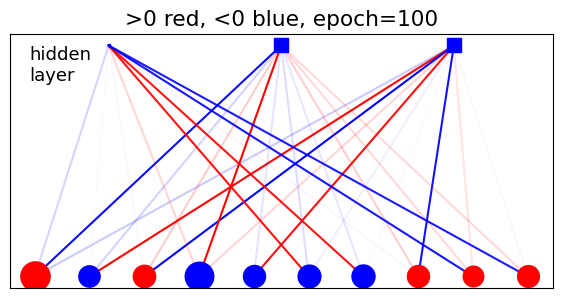

l_rate =  0.5000000000000009


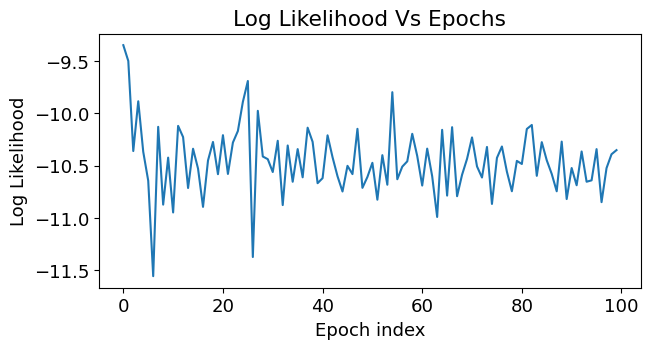

In [4]:
model = RBM(M=3,filename='/x_RBM_2024_exercise.dat',show_info=False)
model.reset_params(show_info=False)
model.train()  #cd_steps=1 by default

each of N=10000 data has L=10 digits
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1]


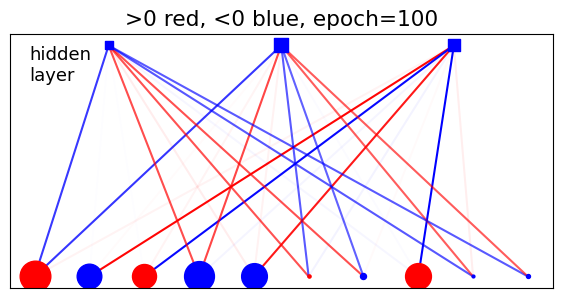

l_rate =  0.5000000000000009


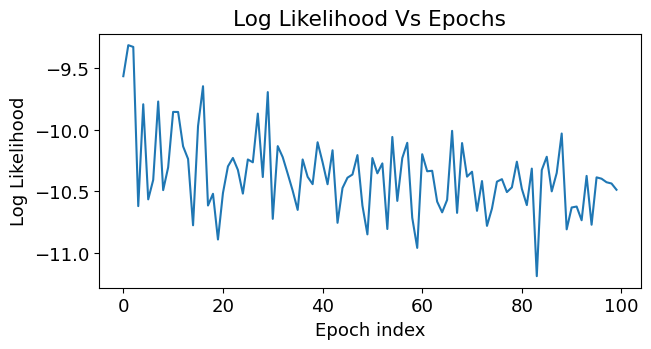

In [5]:
model = RBM(M=3,filename='/x_RBM_2024_exercise.dat',show_info=False)
model.reset_params(show_info=False)
model.train(cd_steps=5)

## Analysis of Lesson dataset

each of N=10000 data has L=12 digits
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1]


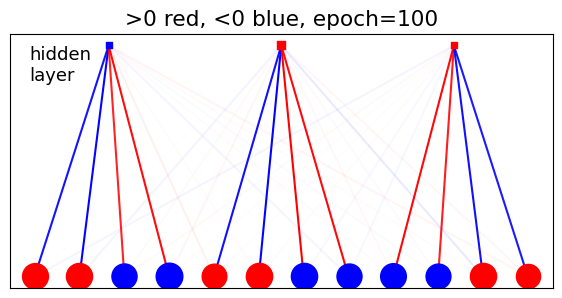

l_rate =  0.5000000000000009


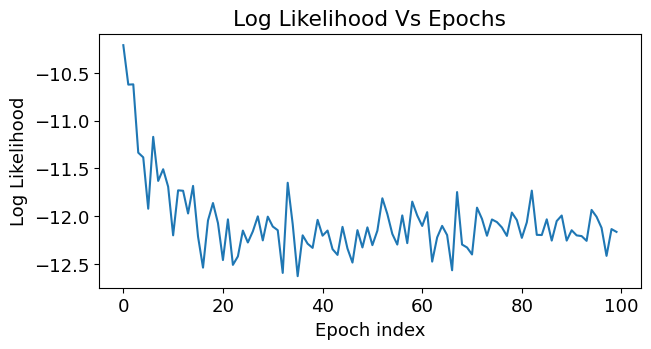

In [6]:
model = RBM(M=3,filename='/x_RBM_2024_lesson.dat',show_info=False)
model.reset_params(show_info=False)
model.train()  #cd_steps=1 by default

each of N=10000 data has L=12 digits
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1]


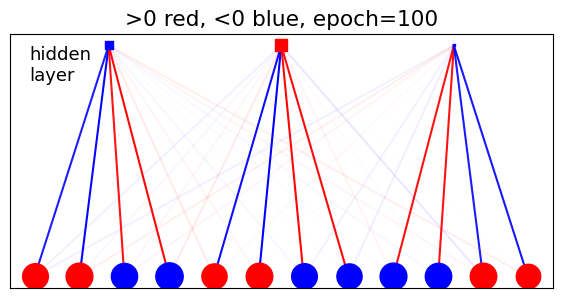

l_rate =  0.5000000000000009


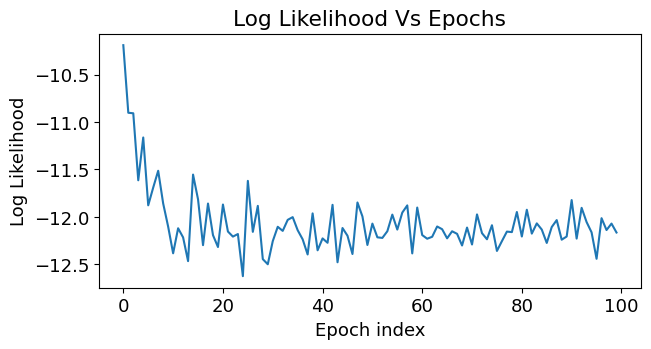

In [7]:
model = RBM(M=3,filename='/x_RBM_2024_lesson.dat',show_info=False)
model.reset_params(show_info=False)
model.train(cd_steps=5)

Point 3

each of N=10000 data has L=10 digits
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1]


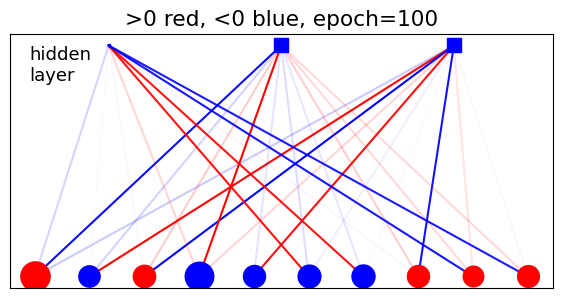

l_rate =  0.5000000000000009


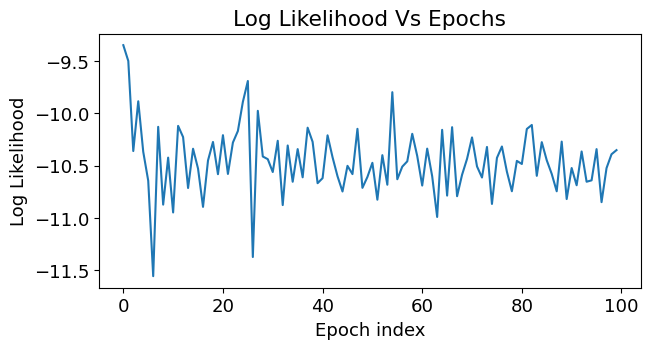

each of N=10000 data has L=10 digits
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1]


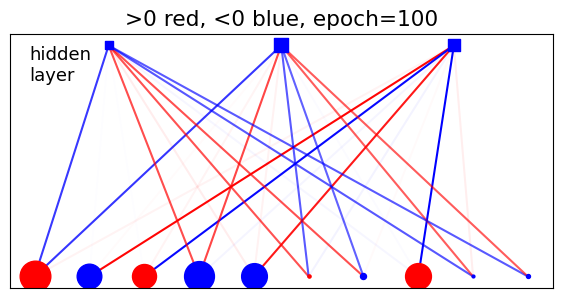

l_rate =  0.5000000000000009


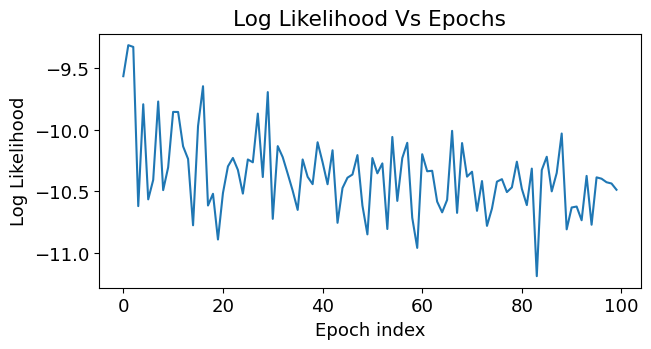

AttributeError: 'RBM' object has no attribute 'log_likelihood_list'

<Figure size 1000x600 with 0 Axes>

In [8]:
#This part of the code will generate a plot comparing the learning progress (measured by log likelihood L)
# over epochs for different numbers of contrastive divergence (CD) 
#steps (n=1 and n=5) with M=3 hidden units.

#initialize RBM models with M=3 file
model_cd1= RBM(M=3, filename='/x_RBM_2024_exercise.dat', show_info= False)
model_cd1.reset_params(show_info=False)
model_cd1.train(cd_steps= 1)

model_cd5 = RBM(M=3, filename='/x_RBM_2024_exercise.dat', show_info=False)
model_cd5.reset_params(show_info=False)
model_cd5.train(cd_steps=5)

# Plot log likelihood (L) as a function of epochs for both CD step cases
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(model_cd1.log_likelihood_list)+1), model_cd1.log_likelihood_list, label='CD Steps = 1')
plt.plot(range(1, len(model_cd5.log_likelihood_list)+1), model_cd5.log_likelihood_list, label='CD Steps = 5')
plt.xlabel('Epochs')
plt.ylabel('Log Likelihood (L)')
plt.title('Log Likelihood (L) vs Epochs for Different CD Steps (M=3)')
plt.legend()
plt.show()


In [ ]:
# Initialize RBM models with different M values
model_M2 = RBM(M=2, filename='/x_RBM_2024_exercise.dat', show_info=False)
model_M2.reset_params(show_info=False)
model_M2.train(cd_steps=1)

model_M4 = RBM(M=4, filename='/x_RBM_2024_exercise.dat', show_info=False)
model_M4.reset_params(show_info=False)
model_M4.train(cd_steps=1)

model_M6 = RBM(M=6, filename='/x_RBM_2024_exercise.dat', show_info=False)
model_M6.reset_params(show_info=False)
model_M6.train(cd_steps=1)

# Plot log likelihood (L) as a function of epochs for different M values
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(model_M2.log_likelihood_list)+1), model_M2.log_likelihood_list, label='M = 2')
plt.plot(range(1, len(model_M4.log_likelihood_list)+1), model_M4.log_likelihood_list, label='M = 4')
plt.plot(range(1, len(model_M6.log_likelihood_list)+1), model_M6.log_likelihood_list, label='M = 6')
plt.xlabel('Epochs')
plt.ylabel('Log Likelihood (L)')
plt.title('Log Likelihood (L) vs Epochs for Different M values (CD Steps = 1)')
plt.legend()
plt.show()